# Satellite image generation (AWS data)

**Libraries needed:**

In [1]:
#---Cloud search libraries
import s3fs #---The installation of this package on conda makes me nervous for the environment stability
import requests
import fnmatch

#---Accessory libraries
import datetime
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt

**Set the datetime and band to view:**

In [2]:
year = 2024
month = 6
day = 6
hour = 6

band = '07' #---Include the leading zero, if needed

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

158


**Connecting to AWS remote storage:**

In [3]:
fs = s3fs.S3FileSystem(anon=True)

**Search the AWS database:**

In [4]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadF' #---Full disk ABI radiance

#---Add band selection here (C**)

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

files_band = [file for file in files if fnmatch.fnmatch(file.split('/')[-1], 'OR_ABI-L1b-RadF-M6C' + band + '*')]

In [5]:
file = files_band[0] #---first is the top-of-the-hour
print(file)

noaa-goes16/ABI-L1b-RadF/2024/158/06/OR_ABI-L1b-RadF-M6C07_G16_s20241580600194_e20241580609513_c20241580609554.nc


In [6]:
resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file[12:])
if str(resp) != '<Response [200]>':
    print('b07 file not found in AWS servers')

**Open the satellite data:**

In [7]:
nc = netCDF4.Dataset(file, memory = resp.content)
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))

In [8]:
ds

<xarray.Dataset>
Dimensions:                                           (y: 5424, x: 5424,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1,
                                                       number_of_harmonization_coefficients: 3,
                                                       num_star_looks: 24)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float64 0.1518 ... ...
  * x                                                 (x) float64 -0.1518 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band, number_of_harmonization_coefficients,
                                num_star_looks
Data variables: (12/39)
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2024-06-06T06:09:55.4Z
    time_coverage_start:       2024-06-06T06:00:19.4Z
    time_coverage_end:         2024-06-06T06:09:51.3Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevH_DO_13_00_00)-7...
    id:                        7c098d0f-2a94-4a58-aa91-eab19b41b08b

**Plot the satellite data:**

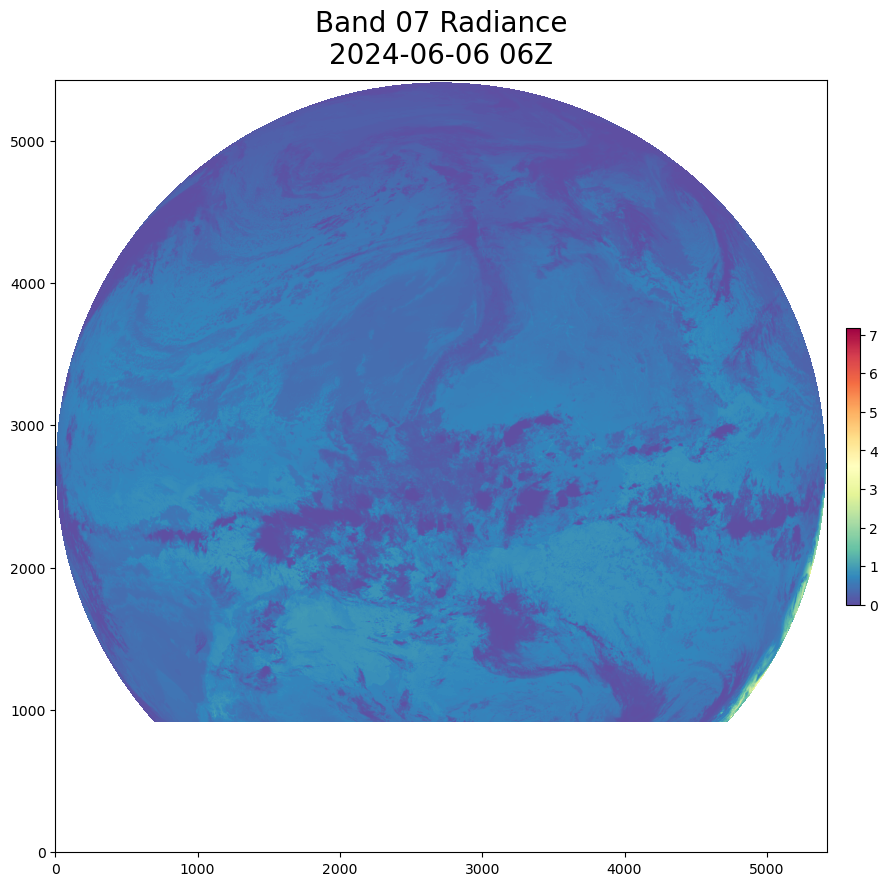

In [9]:
date_formatted = str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+' '+str(hour).zfill(2)+'Z'

fig,ax=plt.subplots(1, figsize=(12,12))
cmap = plt.cm.Spectral_r

img=ax.imshow(ds.Rad, cmap='Spectral_r', origin='lower')
clb=plt.colorbar(img, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Band ' + band + ' Radiance' +'\n'+date_formatted, fontsize=20, pad=12)

plt.show()

**Get the latitudes and longitudes for the satellite image:**
* I have this in my old codes somewhere